In [1]:
%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100

$(".output_scroll").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };
    
    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox',true);
            var div = document.createElement('div');
            var checkbox = document.createElement('input');
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }
        
        $(this)[0].scrollTop = $(this)[0].scrollHeight;
    });
    callScrollToBottom();
}
scrollToBottom();

<IPython.core.display.Javascript object>

In [2]:
#import necessary libraries
import os
import IPython
import librosa as lr
import numpy as np
from datetime import datetime
from packaging import version
import tensorboard
import keras
from keras import layers
from keras import regularizers
import tensorflow as tf
import matplotlib.pyplot as plt
from librosa import display
from tensorflow.keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Flatten,Dense,Activation,Conv2DTranspose
import time
from sklearn import preprocessing

#LOG_DIR = f'{int(time.time())}'

path = 'C:/Users/erikv/Desktop/IP/samples/' #path where the samples are stored'''
dirs = os.listdir(path) #open the directory using os library'''

def rosaspec(sound, NFFT): #defined functions for extracting the spectogram of a sound wave'''
    sound = np.concatenate((np.zeros(int(NFFT/2)),sound,np.zeros(int(NFFT/2))))
    spec_c = lr.stft(sound, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
    return np.concatenate((np.expand_dims(np.real(spec_c),2),np.expand_dims(np.imag(spec_c),2)),axis=2)

def irosaspec(spec,NFFT): #defined function for extracting a soundwave from a spectogram'''
    spec_c = spec[:,:,0].squeeze() + 1j* spec[:,:,1].squeeze()
    return lr.istft(spec_c, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)[int(NFFT/2):-int(NFFT/2)]

In [3]:
NFFT =  int(1022/8) #selection of the NFFT, allows the modification of the sie of 2nd array dimension'''

batchsize = len(dirs) #selection of the batch size'''
testsize = int(0.2*batchsize) #selection of the test batch file'''

yoriginal1,sroriginal1 = lr.load(path+dirs[35],sr=2*8000) #open the audio file (in this case the 
                                                         #test one) using the librosa library'''
yoriginal1 = yoriginal1[0:int(len(yoriginal1)/16)] #cropping of the loaded file to half the length for testing purposes'''
#originalspect = lr.stft(yoriginal1, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
asignal = np.array([rosaspec(yoriginal1,NFFT)]) #spectogram extraction from the file'''
audio = asignal/asignal.max() #normalized values to be between 0 and 1
test= audio


print (test.shape,test.max(),test.min())

(1, 64, 64, 2) 1.0 -0.9775807792232803


In [4]:
starting = irosaspec(test[0],NFFT)
IPython.display.display(IPython.display.Audio(starting,rate = sroriginal1)) #check if the audio has been correctly loaded

In [5]:
processed = np.zeros([batchsize, 64, 64, 2]) #prepare a 0 array. The processes is a loop using the same 
                                               #procedure as explained before
for i in range(batchsize):
    yoriginal,sroriginal = lr.load(path+dirs[i],sr=2*8000) 
    yoriginal = yoriginal[0:int(len(yoriginal)/16)]
    #originalspect = lr.stft(yoriginal, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
    asignal = np.array([rosaspec(yoriginal,NFFT)])
    audio = asignal#/asignal.max()
    processed[i] = audio
    print (i)

print (asignal.shape,processed.shape) #we have now an array of 4096 files in dimensions 256x256x2

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107


3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802


In [6]:
#np.save('processedshorter.npy', processed)
xtrain = np.load('processedshorter.npy')

In [7]:
xtrain.shape

(4096, 64, 64, 2)

In [8]:
device = 'cuda'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) #check if keras is using GPU optimization
if test[0,20,20,0] == xtrain[35,20,20,0]: #if these two numbers are the same the files are coincident and correct loading
    print ('--------------loading correct--------------')
else:
    print('--------------loading failed. check coordinates--------------') 

Num GPUs Available:  1
--------------loading failed. check coordinates--------------


In [9]:
#the autoencoder is composed of 4 encoding layers and 4 decoding layers

encoder_input = keras.Input(shape=(64, 64, 2), name="original audio")
x = layers.BatchNormalization()(encoder_input)
x = layers.Conv2D(4, 3, activation="relu",padding='same')(x)
x = layers.Conv2D(4, 3, activation="relu",padding='same',strides=(2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(8, 3, activation="relu",padding='same')(x)
x = layers.Conv2D(8, 3, activation="relu",padding='same',strides=(2,2))(x)
#x = layers.Conv2D(16, 3, activation="relu",padding='same')(x)
#x = layers.Conv2D(16, 3, activation="relu",padding='same',strides=(2,2))(x)
#x = layers.Conv2D(16, 3, activation="relu",padding='same')(x)
#x = layers.BatchNormalization()(x)
#x = layers.Conv2D(32, 3, activation="relu",padding='same',strides=(2,2))(x)
#x = layers.Conv2D(32, 3, activation=None,padding='same')(x)
encoder_output = layers.Flatten()(x) #the file is reduced to 8192

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

decoder_input = keras.Input(shape=(2048), name="encoded audio")
x = layers.Reshape((16,16,8))(decoder_input)
#x = layers.Conv2DTranspose(32, 3, activation="relu",padding='same')(x)
#x = layers.Conv2DTranspose(32, 3, activation="relu",padding='same',strides=(2,2))(x)
#x = layers.BatchNormalization()(x)
#x = layers.Conv2DTranspose(16, 3, activation="relu",padding='same')(x)
#x = layers.Conv2DTranspose(16, 3, activation="relu",padding='same',strides=(2,2))(x)
x = layers.Conv2DTranspose(8, 3, activation="relu",padding='same')(x)
x = layers.Conv2DTranspose(8, 3, activation="relu",padding='same',strides=(2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(4, 3, activation="relu",padding='same')(x)
x = layers.Conv2DTranspose(4, 3, activation="relu",padding='same',strides=(2,2))(x)
decoder_output = layers.Conv2DTranspose(2, 3, activation=None,padding='same')(x) #this last layer does not have an activation method

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

autoencoder_input = keras.Input(shape=(64, 64, 2), name="input")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()



Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original audio (InputLayer)  [(None, 64, 64, 2)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 2)         8         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 4)         76        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 4)         148       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 4)         16        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 8)         296       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 8)         584 

In [14]:
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [11]:
autoencoder.compile(optimizer='adam', 
                  loss='mean_squared_error') #the autoencoder is optimizwed using adam and the loss 
                                                              #and metrics are mean logarithmic squared error
autoencoder.fit(xtrain,xtrain,
                epochs=1000,
                batch_size=20,
                shuffle=True,
                validation_split=0.2) #it is trained using a 20% validations. So from the 100 files batch, 80 are for 
                                      #training and 20 are for validation purposes

Epoch 1/1000
164/164 [==============================] - 9s 14ms/step - loss: 2.3060 - val_loss: 1.3524
Epoch 2/1000
164/164 [==============================] - 2s 10ms/step - loss: 1.7912 - val_loss: 0.9977
Epoch 3/1000
164/164 [==============================] - 2s 10ms/step - loss: 1.4678 - val_loss: 0.8868
Epoch 4/1000
164/164 [==============================] - 2s 10ms/step - loss: 1.3204 - val_loss: 0.8354
Epoch 5/1000
164/164 [==============================] - 2s 10ms/step - loss: 1.2367 - val_loss: 0.8050
Epoch 6/1000
164/164 [==============================] - 2s 10ms/step - loss: 1.1873 - val_loss: 0.7676
Epoch 7/1000
164/164 [==============================] - 2s 10ms/step - loss: 1.1401 - val_loss: 0.7357
Epoch 8/1000
164/164 [==============================] - 2s 10ms/step - loss: 1.0995 - val_loss: 0.7101
Epoch 9/1000
164/164 [==============================] - 2s 10ms/step - loss: 1.0533 - val_loss: 0.6671
Epoch 10/1000
164/164 [==============================] - 2s 10ms/step - l

Epoch 80/1000
164/164 [==============================] - 2s 10ms/step - loss: 0.4654 - val_loss: 0.3238
Epoch 81/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.4701 - val_loss: 0.3266
Epoch 82/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.4681 - val_loss: 0.3248
Epoch 83/1000
164/164 [==============================] - 2s 10ms/step - loss: 0.4767 - val_loss: 0.3293
Epoch 84/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.4636 - val_loss: 0.3269
Epoch 85/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.4615 - val_loss: 0.3211
Epoch 86/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.4590 - val_loss: 0.3276
Epoch 87/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.4629 - val_loss: 0.3221
Epoch 88/1000
164/164 [==============================] - 2s 10ms/step - loss: 0.4602 - val_loss: 0.3370
Epoch 89/1000
164/164 [==============================] - 2s 10ms

164/164 [==============================] - 2s 12ms/step - loss: 0.4198 - val_loss: 0.3023
Epoch 159/1000
164/164 [==============================] - 2s 12ms/step - loss: 0.4247 - val_loss: 0.2955
Epoch 160/1000
164/164 [==============================] - 2s 12ms/step - loss: 0.4184 - val_loss: 0.2933
Epoch 161/1000
164/164 [==============================] - 2s 12ms/step - loss: 0.4204 - val_loss: 0.2973
Epoch 162/1000
164/164 [==============================] - 2s 12ms/step - loss: 0.4263 - val_loss: 0.2965
Epoch 163/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.4197 - val_loss: 0.2900
Epoch 164/1000
164/164 [==============================] - 2s 12ms/step - loss: 0.4185 - val_loss: 0.2927
Epoch 165/1000
164/164 [==============================] - 2s 12ms/step - loss: 0.4169 - val_loss: 0.2928
Epoch 166/1000
164/164 [==============================] - 2s 12ms/step - loss: 0.4184 - val_loss: 0.2915
Epoch 167/1000
164/164 [==============================] - 2s 12ms/step

164/164 [==============================] - 2s 11ms/step - loss: 0.4071 - val_loss: 0.2800
Epoch 237/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.4054 - val_loss: 0.2801
Epoch 238/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.4036 - val_loss: 0.2915
Epoch 239/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.4050 - val_loss: 0.2950
Epoch 240/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.4046 - val_loss: 0.2871
Epoch 241/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.4126 - val_loss: 0.2810
Epoch 242/1000
164/164 [==============================] - 2s 10ms/step - loss: 0.3987 - val_loss: 0.2815
Epoch 243/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.4020 - val_loss: 0.2810
Epoch 244/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.4069 - val_loss: 0.2871
Epoch 245/1000
164/164 [==============================] - 2s 11ms/step

164/164 [==============================] - 2s 11ms/step - loss: 0.3955 - val_loss: 0.2768
Epoch 315/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3944 - val_loss: 0.2770
Epoch 316/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3978 - val_loss: 0.2761
Epoch 317/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3981 - val_loss: 0.2753
Epoch 318/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3936 - val_loss: 0.2787
Epoch 319/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3943 - val_loss: 0.2755
Epoch 320/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.4039 - val_loss: 0.2747
Epoch 321/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3927 - val_loss: 0.2887
Epoch 322/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3976 - val_loss: 0.2752
Epoch 323/1000
164/164 [==============================] - 2s 11ms/step

164/164 [==============================] - 2s 11ms/step - loss: 0.3894 - val_loss: 0.2726
Epoch 393/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3910 - val_loss: 0.2707
Epoch 394/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3858 - val_loss: 0.2720
Epoch 395/1000
164/164 [==============================] - 2s 10ms/step - loss: 0.3807 - val_loss: 0.2686
Epoch 396/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3921 - val_loss: 0.2830
Epoch 397/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3884 - val_loss: 0.2843
Epoch 398/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3958 - val_loss: 0.2705
Epoch 399/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3854 - val_loss: 0.2739
Epoch 400/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3919 - val_loss: 0.2700
Epoch 401/1000
164/164 [==============================] - 2s 11ms/step

164/164 [==============================] - 2s 11ms/step - loss: 0.3843 - val_loss: 0.2755
Epoch 471/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3834 - val_loss: 0.2725
Epoch 472/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3831 - val_loss: 0.2680
Epoch 473/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3843 - val_loss: 0.2742
Epoch 474/1000
164/164 [==============================] - 2s 10ms/step - loss: 0.3916 - val_loss: 0.2756
Epoch 475/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3822 - val_loss: 0.2750
Epoch 476/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3832 - val_loss: 0.2691
Epoch 477/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3823 - val_loss: 0.2699
Epoch 478/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3828 - val_loss: 0.2714
Epoch 479/1000
164/164 [==============================] - 2s 11ms/step

164/164 [==============================] - 2s 11ms/step - loss: 0.3778 - val_loss: 0.2666
Epoch 549/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3762 - val_loss: 0.2649
Epoch 550/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3736 - val_loss: 0.2641
Epoch 551/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3770 - val_loss: 0.2648
Epoch 552/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3735 - val_loss: 0.2670
Epoch 553/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3755 - val_loss: 0.2675
Epoch 554/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3744 - val_loss: 0.2657
Epoch 555/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3720 - val_loss: 0.2723
Epoch 556/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3802 - val_loss: 0.2691
Epoch 557/1000
164/164 [==============================] - 2s 11ms/step

164/164 [==============================] - 2s 11ms/step - loss: 0.3701 - val_loss: 0.2684
Epoch 627/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3737 - val_loss: 0.2631
Epoch 628/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3720 - val_loss: 0.2637
Epoch 629/1000
164/164 [==============================] - 2s 12ms/step - loss: 0.3705 - val_loss: 0.2693
Epoch 630/1000
164/164 [==============================] - 2s 12ms/step - loss: 0.3760 - val_loss: 0.2648
Epoch 631/1000
164/164 [==============================] - 2s 12ms/step - loss: 0.3734 - val_loss: 0.2740
Epoch 632/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3728 - val_loss: 0.2658
Epoch 633/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3704 - val_loss: 0.2655
Epoch 634/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3748 - val_loss: 0.2724
Epoch 635/1000
164/164 [==============================] - 2s 10ms/step

164/164 [==============================] - 2s 11ms/step - loss: 0.3714 - val_loss: 0.2616
Epoch 705/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3680 - val_loss: 0.2605
Epoch 706/1000
164/164 [==============================] - 2s 12ms/step - loss: 0.3672 - val_loss: 0.2625
Epoch 707/1000
164/164 [==============================] - 2s 12ms/step - loss: 0.3678 - val_loss: 0.2577
Epoch 708/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3654 - val_loss: 0.2609
Epoch 709/1000
164/164 [==============================] - 2s 12ms/step - loss: 0.3696 - val_loss: 0.2669
Epoch 710/1000
164/164 [==============================] - 2s 12ms/step - loss: 0.3663 - val_loss: 0.2631
Epoch 711/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3656 - val_loss: 0.2651
Epoch 712/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3686 - val_loss: 0.2621
Epoch 713/1000
164/164 [==============================] - 2s 12ms/step

164/164 [==============================] - 2s 12ms/step - loss: 0.3622 - val_loss: 0.2630
Epoch 783/1000
164/164 [==============================] - 2s 12ms/step - loss: 0.3625 - val_loss: 0.2609
Epoch 784/1000
164/164 [==============================] - 2s 12ms/step - loss: 0.3617 - val_loss: 0.2576
Epoch 785/1000
164/164 [==============================] - 2s 12ms/step - loss: 0.3628 - val_loss: 0.2617
Epoch 786/1000
164/164 [==============================] - 2s 12ms/step - loss: 0.3705 - val_loss: 0.2627
Epoch 787/1000
164/164 [==============================] - 2s 12ms/step - loss: 0.3673 - val_loss: 0.2585
Epoch 788/1000
164/164 [==============================] - 2s 12ms/step - loss: 0.3677 - val_loss: 0.2577
Epoch 789/1000
164/164 [==============================] - 2s 12ms/step - loss: 0.3639 - val_loss: 0.2592
Epoch 790/1000
164/164 [==============================] - 2s 12ms/step - loss: 0.3670 - val_loss: 0.2559
Epoch 791/1000
164/164 [==============================] - 2s 12ms/step

164/164 [==============================] - 2s 11ms/step - loss: 0.3644 - val_loss: 0.2577
Epoch 861/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3598 - val_loss: 0.2584
Epoch 862/1000
164/164 [==============================] - 2s 10ms/step - loss: 0.3568 - val_loss: 0.2566
Epoch 863/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3638 - val_loss: 0.2589
Epoch 864/1000
164/164 [==============================] - 2s 10ms/step - loss: 0.3665 - val_loss: 0.2564
Epoch 865/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3576 - val_loss: 0.2537
Epoch 866/1000
164/164 [==============================] - 2s 10ms/step - loss: 0.3650 - val_loss: 0.2586
Epoch 867/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3654 - val_loss: 0.2605
Epoch 868/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3629 - val_loss: 0.2618
Epoch 869/1000
164/164 [==============================] - 2s 11ms/step

164/164 [==============================] - 2s 10ms/step - loss: 0.3595 - val_loss: 0.2517
Epoch 939/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3565 - val_loss: 0.2549
Epoch 940/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3564 - val_loss: 0.2529
Epoch 941/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3578 - val_loss: 0.2504
Epoch 942/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3588 - val_loss: 0.2503
Epoch 943/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3568 - val_loss: 0.2501
Epoch 944/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3591 - val_loss: 0.2530
Epoch 945/1000
164/164 [==============================] - 2s 11ms/step - loss: 0.3581 - val_loss: 0.2530
Epoch 946/1000
164/164 [==============================] - 2s 10ms/step - loss: 0.3525 - val_loss: 0.2554
Epoch 947/1000
164/164 [==============================] - 2s 10ms/step

%tensorboard --reuse_port False
%tensorboard --logdir log_dir

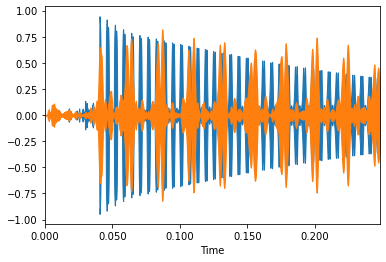

In [13]:
n = 10
decoded_array = np.array(autoencoder(np.array([xtrain[n]]))) #a sample file is runned through the autoencoder
decoded_audio = irosaspec(decoded_array[0],NFFT) #the output array is transformed into audio using the reverse spectogram fnct.

deprobe = irosaspec(xtrain[n],NFFT) #this is just the sample file runned directly from the processed array NOT the autoenc.

plt.figure()
#plt.subplot(1, 2, 2) 
lr.display.waveplot(y=yoriginal1,sr=sroriginal1)
#plt.subplot(1, 2, 2) 
lr.display.waveplot(y=decoded_audio,sr=sroriginal1)
plt.show()

IPython.display.display(IPython.display.Audio(deprobe,rate = sroriginal1))
IPython.display.display(IPython.display.Audio(decoded_audio,rate=sroriginal1))

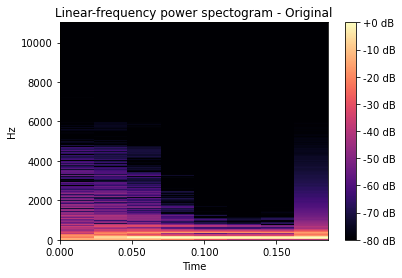

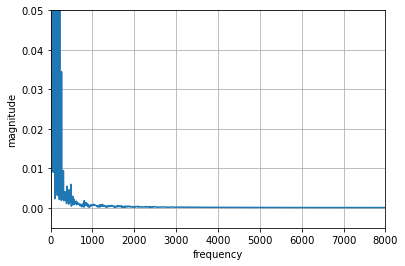

In [20]:
y, sr = deprobe, sroriginal1
D = lr.amplitude_to_db(np.abs(lr.stft(y)), ref=np.max)
fig, ax = plt.subplots()
img = lr.display.specshow(D, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Linear-frequency power spectogram - Original')
fig.colorbar(img, ax=ax, format="%+2.f dB")
fftpl(deprobe,sroriginal1)

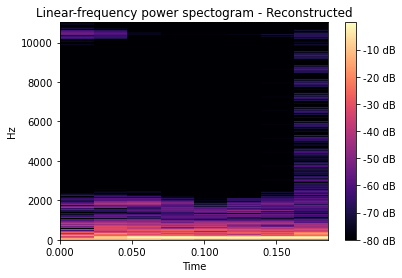

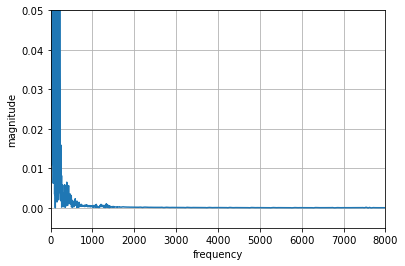

In [21]:
y, sr = decoded_audio, sroriginal1
D = lr.amplitude_to_db(np.abs(lr.stft(y)), ref=np.max)
fig, ax = plt.subplots()
img = lr.display.specshow(D, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Linear-frequency power spectogram - Reconstructed')
fig.colorbar(img, ax=ax, format="%+2.f dB")
fftpl(decoded_audio,sroriginal1)

In [19]:
from scipy.fft import fft,fftfreq
def fftpl(audio,sr):
    n = len(audio)
    T = 1/sr
    yf = fft(audio)
    xf = fftfreq(n,T)[:n//2]
    fig,ax = plt.subplots()
    A = ax.plot(xf,2.0/n * np.abs(yf[:n//2]))
    plt.grid()
    plt.xlabel("frequency")
    plt.ylabel("magnitude")
    plt.axis([0,8000,-0.005,0.05])
    return A

In [74]:
autoencoder.save("autoencoder_v26")
#encoder.save("encoder_v23")

INFO:tensorflow:Assets written to: autoencoder_v26\assets


In [20]:
#autoencoder = tf.keras.models.load_model('autoencoder_v23')
#encoder =  tf.keras.models.load_model('encoder_v23')

In [23]:
encoded_vector = encoder(np.array([xtrain[n]])).reshape((512,2))
t = np.linspace(0,16384,1024)
plt.plot(t,encoded_vector[0])

AttributeError: 
        'EagerTensor' object has no attribute 'reshape'.
        If you are looking for numpy-related methods, please run the following:
        from tensorflow.python.ops.numpy_ops import np_config
        np_config.enable_numpy_behavior()

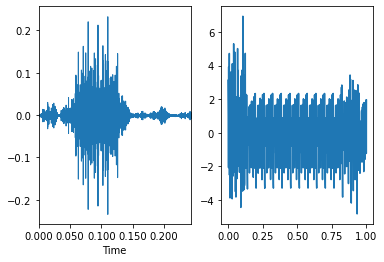

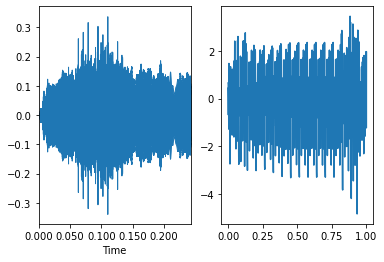

In [24]:
t = np.linspace(0,1,1024)
for i in [123,556]:
    encoded_vector = encoder(np.array([xtrain[i]]))
    decoded_array = np.array(autoencoder(np.array([xtrain[i]])))
    decoded_audio = irosaspec(decoded_array[0],NFFT)
    original = irosaspec(xtrain[i],NFFT)
    plt.figure()
    plt.subplot(1, 2, 2)
    plt.plot(t,encoded_vector[0])
    plt.subplot(1, 2, 1) 
    lr.display.waveplot(y=decoded_audio,sr=sroriginal1)
    IPython.display.display(IPython.display.Audio(decoded_audio,rate = sroriginal1))
    IPython.display.display(IPython.display.Audio(original,rate = sroriginal1))

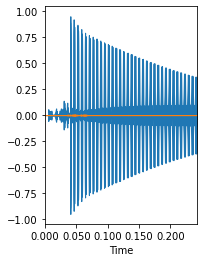

In [46]:
encoded_array = encoder(test)
encoded_array

<tf.Tensor: shape=(1, 80, 80, 64), dtype=float32, numpy=
array([[[[0.00000000e+00, 0.00000000e+00, 8.88219833e+00, ...,
          3.21911931e+00, 2.09728851e+01, 6.77881861e+00],
         [8.29132855e-01, 1.42069111e+01, 0.00000000e+00, ...,
          2.62937050e+01, 1.10293665e+01, 1.40658188e+01],
         [1.10255928e+01, 1.48785734e+01, 0.00000000e+00, ...,
          3.30265880e+00, 0.00000000e+00, 5.44991732e+00],
         ...,
         [0.00000000e+00, 1.78576875e+00, 3.59359458e-02, ...,
          2.17136931e+00, 1.84202945e+00, 2.03786993e+00],
         [0.00000000e+00, 1.18344620e-01, 5.13677645e+00, ...,
          1.31172073e+00, 1.50830758e+00, 0.00000000e+00],
         [0.00000000e+00, 2.98698592e+00, 6.61337996e+00, ...,
          0.00000000e+00, 0.00000000e+00, 2.77210236e+00]],

        [[7.20693398e+00, 3.28745055e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 2.29155040e+00],
         [4.32349491e+00, 4.35678661e-03, 0.00000000e+00, ...,
          

In [14]:
print(decoded_array.shape)

(100, 256, 256, 2)


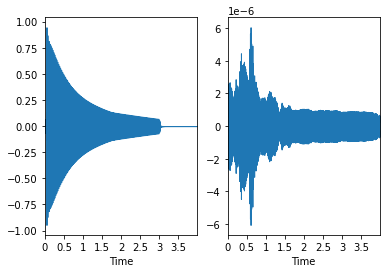

In [58]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Setting standard filter requirements.
order = 6
fs = 30.0       
cutoff = 8

b, a = butter_lowpass(cutoff, fs, order)

filtered1 = butter_lowpass_filter(yoriginal1, cutoff, fs, order)
filtered = butter_lowpass_filter(decoded_audio, cutoff, fs, order)
plt.figure()
plt.subplot(1, 2, 2) 
lr.display.waveplot(y=filtered,sr=sroriginal)
plt.subplot(1, 2, 1) 
lr.display.waveplot(y=yoriginal1,sr=sroriginal)
plt.show()

IPython.display.display(IPython.display.Audio(yoriginal1,rate=sroriginal))
IPython.display.display(IPython.display.Audio(filtered,rate=sroriginal))

In [102]:
audio.max(), audio.min()

(1.0, -0.856759766190995)

In [89]:
print(yoriginal.shape)
print(enprobe.shape)
print(deprobe.shape)
print(decoded_array.shape)
print(decoded_audio.shape)



(64000,)
(504, 128, 2)
(63881,)
(504, 128, 2)
(63881,)


(1.0, -0.7587283885818327)

In [81]:
i = 2
j = 4
while i<25600/2:
    NFFT = i
    file = 'C:/Users/erikv/Desktop/IP/samples/bass_electronic_027-056-050.wav'

    yoriginal,sroriginal = lr.load(file,sr=None)
    orginalspect = lr.stft(yoriginal, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
    audio = np.array([rosaspec(yoriginal,NFFT)])

    numbers = audio.shape
    x = numbers[1]
    y = numbers[2]
    if x%j == 0 and y%j == 0:
            print (i)
    i=i+2

110
126
134
166
174
182
254
286
294
302
334
382
406
422
478
486
494
518
526
534
582
606
630
654
670
766
782
822
846
870
894
918
942
974
1006
1038
1070
1110
1150
1190
1238
1286
1334
1342
1398
1406
1462
1470
1526
1534
1542
1606
1614


KeyboardInterrupt: 

<IPython.core.display.Javascript object>